In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import copy

In [3]:
#load images
left, right = glob.glob("mynteye/left*.png"), glob.glob("mynteye/right*.png")

In [13]:
row, col = 6, 9
objp = np.zeros((row*col, 3), np.float32)
objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

obj = []
impl= []
impr = []

for imgl, imgr in zip(left, right):
    imgL = cv2.imread(imgl)
    retl, corners_l = cv2.findChessboardCorners(imgL, (row, col))
    im_l = copy.deepcopy(imgL)
    cv2.drawChessboardCorners(im_l, (row, col), corners_l, retl)
    
    imgR = cv2.imread(imgr)
    retr, corners_r = cv2.findChessboardCorners(imgR, (row, col))
    im_r = copy.deepcopy(imgR)
    cv2.drawChessboardCorners(im_r, (row, col), corners_r, retr)
    
    h, w = imgR.shape[:2]
    
    cv2.imshow('left', im_l)
    cv2.imshow('right', im_r)
    cv2.waitKey(500)
    
    if retl == True & retr == True:
        obj.append(objp)
        impl.append(corners_l)
        impr.append(corners_r)

cv2.destroyAllWindows()

retl, mtxl, distl, rvecsl, tvecsl = cv2.calibrateCamera(obj, impl, (w,h), None, None)
retr, mtxr, distr, rvecsr, tvecsr = cv2.calibrateCamera(obj, impr, (w,h), None, None)

omtxl, roil = cv2.getOptimalNewCameraMatrix(mtxl, distl, (w,h), 1, (w,h))
omtxr, roir = cv2.getOptimalNewCameraMatrix(mtxr, distr, (w,h), 1, (w,h))

In [ ]:
dstL = []
dstR = []

for l, r in zip(left, right):
    l = cv2.imread(l)
    r = cv2.imread(r)
    
    dst_l = cv2.undistort(l, mtxl, distl)
    dst_r = cv2.undistort(r, mtxr, distr)
    
    dstL.append(dst_l)
    dstR.append(dst_r)

In [14]:
flags = 0
flags |= cv2.CALIB_FIX_ASPECT_RATIO
flags |= cv2.CALIB_ZERO_TANGENT_DIST
flags |= cv2.CALIB_SAME_FOCAL_LENGTH
flags |= cv2.CALIB_RATIONAL_MODEL
flags |= cv2.CALIB_FIX_K3
flags |= cv2.CALIB_FIX_K4
flags |= cv2.CALIB_FIX_K5

cri = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

ret, mtxl, distl, mtxr, distr, R, T, E, F = cv2.stereoCalibrate(obj, impl, impr, omtxl, distl, omtxr, distr, 
                                                                (w,h), 
                                                                criteria = cri, 
                                                                flags = flags)

In [15]:
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtxl, distl, mtxr, distr, (w,h), R, T)

In [16]:
mapl1, mapl2 = cv2.initUndistortRectifyMap(mtxl, distl, R1, P1, (w,h), cv2.CV_32FC1)
mapr1, mapr2 = cv2.initUndistortRectifyMap(mtxr, distr, R2, P2, (w,h), cv2.CV_32FC1)

In [17]:
im_l = cv2.imread(left[0])
im_r = cv2.imread(right[0])

im__l = cv2.remap(im_l, mapl1, mapl2, cv2.INTER_LINEAR)
im__r = cv2.remap(im_r, mapr1, mapr2, cv2.INTER_LINEAR)

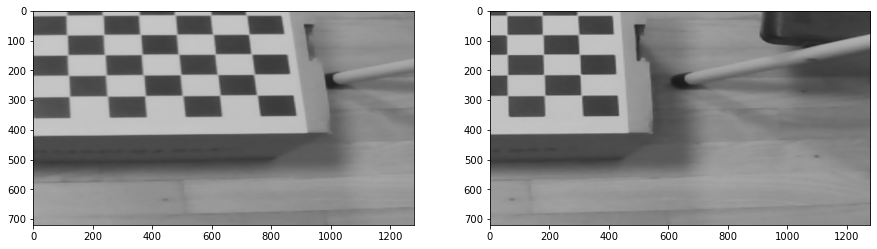

In [19]:
#show them
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im__l)
plt.subplot(1,2,2)
plt.imshow(im__r)